In [1]:
import pandas as pd
import datetime as dt

In [8]:
data_dir = '/Users/vinay/dev/baseball_sql/data'

In [2]:
def generate_game_id(dt, home_team, double_header):
    return(home_team + dt.strftime("%Y%m%d") + str(double_header))

def generate_game_id_from_row(row):
    return (generate_game_id(row['date'], row['home_team'], row['double_header']))

generate_game_id(dt.date(1931,4,14), 'CLE', 0)

'CLE193104140'

In [3]:
# classify the game as RS/PS/ASG
# This simple logic might mis-classify some games.  Will likely need to handle edge cases
# This logic will definitely break for 2020

# There's value in further breaking down post-season games by round.  Also in having multiple fields
# (e.g., boolean fields).  Let's start here, and figure out what makes sense for usability.
def get_game_type(dt, home_team, home_team_game_number):
    if home_team in ['ALS', 'AL1', 'AL2', 'NLS', 'NL1', 'NL2']:
        return 'ASG'
    if dt.month >= 9 and home_team_game_number <10:
        return 'PS'
    else:
        return 'RS'
    
def get_game_type_from_row(row):
    return get_game_type(row['date'], row['home_team'], row['home_team_game_number'])
    
get_game_type(dt.date(1931,6,14), 'CLE', 1)

'RS'

In [9]:
gl = pd.read_parquet(f'{data_dir}/retrosheet/2022/gamelog.parquet')

In [10]:
# Fix the typos in column names
column_mapper = {'home_runs_score': 'home_runs_scored', 'vistor_line_score': 'visitor_line_score'}
gl = gl.rename(columns=column_mapper)

# Add game IDs and years
gl['game_id'] = gl.apply(generate_game_id_from_row, axis=1)
gl['yr'] = gl['date'].apply(lambda d: d.year)
gl['game_type'] = gl.apply(get_game_type_from_row, axis=1)

# Sort by date
gl = gl.sort_values(by='date')

In [11]:
# Write out to parquet
gl.to_parquet(f'{data_dir}/mine/gamelog_enhanced.parquet')

In [17]:
# Let's see if these game IDs match up with those in the game table
g = pd.read_parquet(f'{data_dir}/retrosheet/2022/game.parquet')
g['yr'] = g['game_dt'].dt.year

In [18]:
# Should see that there are no game IDs in game that aren't also in gamelog (e.g. no False values)
g['game_id'].isin(gl['game_id']).value_counts()

True    188294
Name: game_id, dtype: int64

In [19]:
# We can see that some games in gamelog are missing in the game table
gl[gl['yr']>=1934]['game_id'].isin(g[g['yr']>=1934]['game_id']).value_counts()

True     165834
False         3
Name: game_id, dtype: int64

<AxesSubplot:>

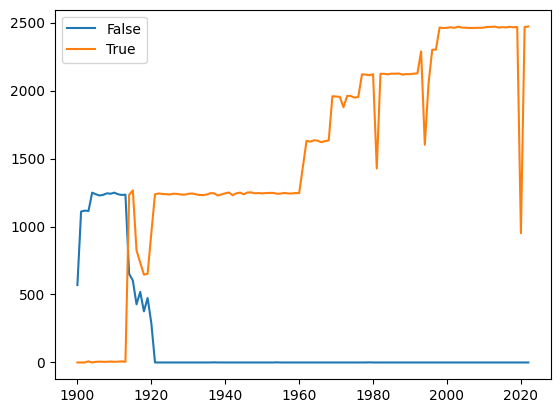

In [20]:
# We can see that some games are missing in the game table.  How many by year?
counts = {}
for yr in range(1900, 2023):
    counts[yr] = gl[gl['yr']==yr]['game_id'].isin(g[g['yr']==yr]['game_id']).value_counts()

pd.DataFrame.from_dict(counts, orient='index').fillna(0).sort_index().plot.line()